# Diamond Price Prediction Using K-Nearest Neighbours Regression Algorithm 

###### Group 5: Jason Wang, Jessie Sheng, Wendy Phung, Clare Pan

## 1 Introduction

Diamond is one of the rarest and hardest naturally occurring substance minerals that are composed of carbon. Because of its optical property, diamond has become the world's most popular gemstone, and it is one of the gemstones in which more money is spent than any other combined gemstone. (Sharma et. al, 2021). Every diamond is unique and the Gemological Institute of America (GIA) has created a globally accepted system for assessing the diamond's quality using the "4Cs": carat for the weight of the diamond, color, clarity, and cut to identify the grade of the diamond. (GIA, n.d.). Since there are three different factors to determine the diamond's grade and also the fluctuation in the diamond market, the price of diamonds is complex to predict. In this report, we aim to use the k-Nearest Neighbors (kNN) Algorithm to predict the diamond price.


The k-nearest neighbor (kNN) algorithm is a simple, supervised machine learning algorithm that can be used to solve both classification and regression problem. In regression problem, KNN algorithm stores all available cases and predict the numerical target based on the similarity measure. KNN models are easy to implement and handle non-linearities well, fitting model process also tends to be quick since the computer does not have to calculate any particular parameters or value. However, while it is quick to set up, it is slower to predict, since it have to search through all the points in it training set to find the nearest one. 

A publicly-available diamond dataset obtained from Caliskan(2021) data set on Kaggle is used in this report to train the KNN regression model, and the 4Cs will be used as the predictors. 

## 2 Methods and Results

We begin the analysis by loading, wrangling and exploring the data set to get a better understanding of the data. Then, 

In [136]:
# loading libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
library(cowplot)
library(kknn)
library(plyr)

options(repr.matrix.max.rows = 8)

# setting the seed
set.seed(1)

### 2.1 Loading the diamonds data

We initially attempted to load the diamonds data set from the original source on the web, Kaggle, but there was no direct access to csv file. To solve this, we downloaded the data set and uploaded it onto a public GitHub repository, from which we were able to access it from the Jupyter notebook.

In [137]:
url <- "https://raw.githubusercontent.com/cpan0/project_proposal/main/diamonds.csv"
diamonds <- read_csv(url)
diamonds

Parsed with column specification:
cols(
  carat = col_double(),
  cut = col_character(),
  color = col_character(),
  clarity = col_character(),
  depth = col_double(),
  table = col_double(),
  x = col_double(),
  y = col_double(),
  z = col_double(),
  price = col_double()
)



carat,cut,color,clarity,depth,table,x,y,z,price
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.23,Ideal,E,SI2,61.5,55,3.95,3.98,2.43,326
0.21,Premium,E,SI1,59.8,61,3.89,3.84,2.31,326
0.23,Good,E,VS1,56.9,65,4.05,4.07,2.31,327
0.29,Premium,I,VS2,62.4,58,4.20,4.23,2.63,334
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.72,Good,D,SI1,63.1,55,5.69,5.75,3.61,2757
0.70,Very Good,D,SI1,62.8,60,5.66,5.68,3.56,2757
0.86,Premium,H,SI2,61.0,58,6.15,6.12,3.74,2757
0.75,Ideal,D,SI2,62.2,55,5.83,5.87,3.64,2757


### 2.2 Wrangling the diamonds data

Since the 4Cs of diamond quality is the universal method for assessing the quality of any diamond, anywhere in the world (GIA, n.d.), we are only interested in columns of ```carat``` (carat weight (ct)), ```cut``` (wellness of diamond cut) , ```color``` (diamond colour), ```clarity``` (diamond clarity) and ```price``` (diamond sale price (USD)) to creat a regression model that can predict a diamond's price.

In [138]:
diamonds <- diamonds %>% 
    select(carat, cut, color, clarity, price) %>%   # selecting the necessary variables/columns
    mutate(cut = factor(cut, c("Ideal", "Premium", "Very Good", "Good", "Fair")), # Relevel cut from 'Ideal' to 'Fair'
          clarity = factor(clarity, c("IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1"))) # Relevel clarity from 'IF' (internally flawless) to 'I1' (imperfect)
diamonds

carat,cut,color,clarity,price
<dbl>,<fct>,<chr>,<fct>,<dbl>
0.23,Ideal,E,SI2,326
0.21,Premium,E,SI1,326
0.23,Good,E,VS1,327
0.29,Premium,I,VS2,334
⋮,⋮,⋮,⋮,⋮
0.72,Good,D,SI1,2757
0.70,Very Good,D,SI1,2757
0.86,Premium,H,SI2,2757
0.75,Ideal,D,SI2,2757


In the data set, ```cut```, ```color``` and ```clarity``` are categorical values. We decided to use label encoding to convert the cateorical values into numerical values (Table 1, 2, 3) so KNN algorthim handel such values better (Yadav, 2019). 

Table 1: Cut label assignments

| Cut (categorical) | Cut (Numberical)|
|-------------------|----------------|
| Ideal	            | 1              |
| Premium	        | 2              |
| Very Good	        | 3              |
| Good	            | 4              |
| Fair	            | 5              |

Table 2: Clarity label assignments

| Clarity (categorical) | Clarity (Numberical)|
|-----------------------|--------------------|
| IF	                | 1                  |
| VVS1	                | 2                  |
| VVS2	                | 3                  |
| VS1	                | 4                  |
| VS2	                | 5                  |
| SI1	                | 6                  |
| SI2	                | 7                  |
| I1	                | 8                  |

Table 3: Colour label assignments

| Colour (categorical) | Colour (Numberical)|
|----------------------|-------------------|
| D	                   | 1                 |
| E	                   | 2                 |
| F	                   | 3                 |
| G	                   | 4                 |
| H	                   | 5                 |
| I	                   | 6                 |
| J	                   | 7                 |

In [139]:
cut_labels <- c("Ideal" = 1, "Premium" = 2, "Very Good" = 3, "Good" = 4, "Fair" = 5)
clarity_labels <- c("IF" = 1, "VVS1" = 2, "VVS2" = 3, "VS1" = 4, "VS2" = 5, "SI1" = 6, "SI2" = 7, "I1" = 8)
color_labels <- c("D" = 1, "E" = 2, "F" = 3, "G" = 4, "H" = 5, "I" = 6, "J" = 7)

#relabeling factors into numerical values
diamonds <- diamonds %>%
    mutate(cut = revalue(cut, cut_labels),
          clarity = revalue(clarity, clarity_labels),
          color = revalue(color, color_labels)) %>%
    mutate(cut = as.numeric(cut),
          clarity = as.numeric(clarity),
          color = as.numeric(color))
head(diamonds)

carat,cut,color,clarity,price
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.23,1,2,7,326
0.21,2,2,6,326
0.23,4,2,4,327
0.29,2,6,5,334
0.31,4,7,7,335
0.24,3,7,3,336


### 2.3 Splitting the diamonds data

To train our regression model, we first tried out different proportions of training and testing splits, ranging from 70% - 90% training data and the remaining 30% - 10% testing data. As this process is random, we set the seed so that our code is reproducible; the ```set.seed``` function acts as a random number generator, with the sequence of values being predetermined by the seed value (cite textbook).

In [140]:
set.seed(1)
diamonds_split <- initial_split(diamonds, prop = 0.93, strata = price)
diamonds_train <- training(diamonds_split)
diamonds_test <- testing(diamonds_split) 

### 2.3 Exploratory Data Analysis

We perform an explanatory data analysis on the diamonds data set to summarize the main characteristics and to get a better understand of the data.

In [141]:
glimpse(diamonds_train)

Rows: 50,167
Columns: 5
$ carat   <dbl> 0.23, 0.21, 0.23, 0.29, 0.31, 0.24, 0.24, 0.26, 0.22, 0.23, 0…
$ cut     <dbl> 1, 2, 4, 2, 4, 3, 3, 3, 5, 3, 4, 1, 2, 1, 2, 2, 1, 4, 4, 3, 4…
$ color   <dbl> 2, 2, 2, 6, 7, 7, 6, 5, 2, 5, 7, 7, 3, 7, 2, 2, 6, 7, 7, 7, 6…
$ clarity <dbl> 7, 6, 4, 5, 7, 3, 2, 6, 5, 4, 6, 4, 6, 7, 7, 8, 7, 6, 6, 6, 7…
$ price   <dbl> 326, 326, 327, 334, 335, 336, 336, 337, 337, 338, 339, 340, 3…


In [142]:
glimpse(diamonds_test)

Rows: 3,773
Columns: 5
$ carat   <dbl> 0.23, 0.30, 0.30, 0.26, 0.24, 0.70, 0.61, 0.63, 0.70, 0.70, 0…
$ cut     <dbl> 3, 1, 3, 3, 2, 2, 3, 2, 3, 2, 2, 4, 2, 2, 1, 1, 1, 2, 3, 1, 5…
$ color   <dbl> 1, 6, 6, 2, 5, 3, 1, 2, 1, 2, 2, 1, 6, 3, 5, 1, 3, 4, 4, 5, 6…
$ clarity <dbl> 5, 7, 6, 2, 2, 5, 3, 2, 4, 6, 4, 5, 2, 4, 5, 6, 8, 4, 4, 5, 6…
$ price   <dbl> 357, 405, 405, 554, 554, 2762, 2763, 2765, 2777, 2777, 2782, …


#### Range, mean and standard deviation of diamond carat in the training data

In [143]:
diamonds_carat_min_max <- diamonds_train %>% 
    summarize(min_carat = min(carat),
             max_carat = max(carat),
             mean_carat = mean(carat),
             sd_carat = sd(carat))
diamonds_carat_min_max

min_carat,max_carat,mean_carat,sd_carat
<dbl>,<dbl>,<dbl>,<dbl>
0.2,5.01,0.7982064,0.4745441


In the diamonds training data set, the minimum and maximum diamond carat weight is found to be 0.2ct and 5.01ct, respectively. The mean of the diamond carat weight is found to be 0.80ct, and the sd is found to be 0.47ct.

#### Number of each cuts in the training data

In [144]:
diamonds_cut_n <- diamonds_train %>% 
    group_by(cut) %>% 
    dplyr::summarize(n = n())
diamonds_cut_n

`summarise()` ungrouping output (override with `.groups` argument)



cut,n
<dbl>,<int>
1,20014
2,12868
3,11227
4,4557
5,1501


The diamond training data set have the most premium cut diamonds (20014), while there are the least fair cut diamonds (1501).

#### Number of each clarity in the training data

In [145]:
diamonds_clarity_n <- diamonds_train %>% 
    group_by(clarity) %>% 
    dplyr::summarize(n = n())
diamonds_clarity_n

`summarise()` ungrouping output (override with `.groups` argument)



clarity,n
<dbl>,<int>
1,1675
2,3400
3,4694
4,7613
5,11355
6,12192
7,8548
8,690


The largest amount of training diamonds has SI1 clarity (12192), and the smallest amount of training diamonds has I1 clarity (690).

#### Number of each color in the training data

In [146]:
diamonds_color_n <- diamonds_train %>% 
    group_by(color) %>% 
    dplyr::summarize(n = n())
diamonds_color_n

`summarise()` ungrouping output (override with `.groups` argument)



color,n
<dbl>,<int>
1,6312
2,9142
3,8904
4,10459
5,7693
6,5032
7,2625


The training data set have the most diamonds with colour G (10459), and few diamonds with colour J (2625).

#### Range, mean and standard deviation of diamond price in the training data

In [147]:
diamonds_price_min_max <- diamonds_train %>% 
    dplyr::summarize(min_price = min(price),
             max_price = max(price),
             mean_price = mean(price),
             sd_price = sd(price))
diamonds_price_min_max

min_price,max_price,mean_price,sd_price
<dbl>,<dbl>,<dbl>,<dbl>
326,18823,3936.277,3994.992


The price value of diamonds in the training data set ranges from \\$326 USD to \\$18823 USD. The mean price of diamonds in the training data set is found to be \\$3936.277 USD, and the standard deviation of the price is \\$3995 USD.

#### Visualization of diamond price v.s. carat weight with respect to cut, clarity, and colour

To visualize the diamonds data set, we choose to use a colourblind friendly palette, ```"BuPu"``` from the ```RColorBrewer``` library so the data points would be easily seen.

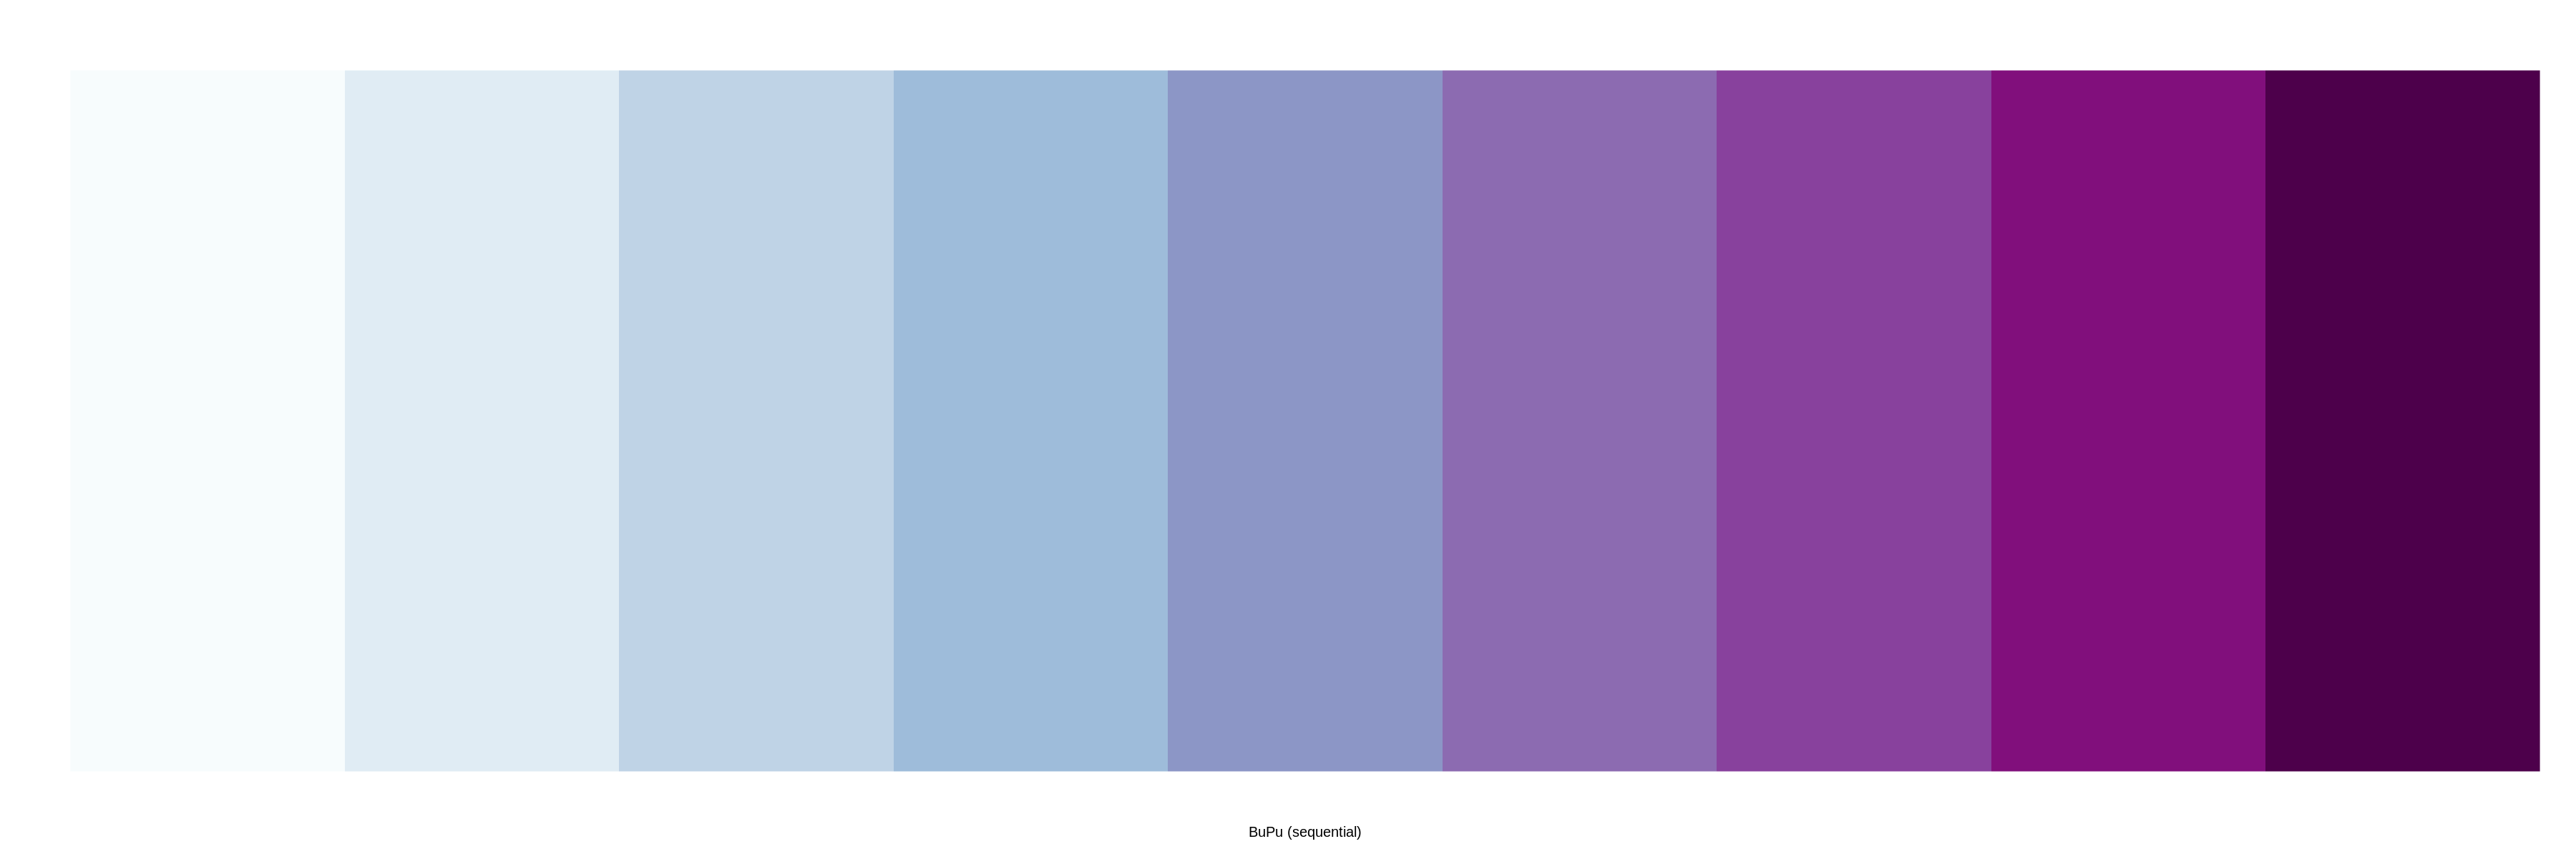

In [148]:
display.brewer.pal(9, "BuPu") 

We find that the first colour in the ```BuPu``` colour palette is too light in colour and is difficult to see. We select all other colours but the first one in the palette for our visualization.

In [149]:
selected_colours <- brewer.pal(9, "BuPu")[2:9]
selected_colours

[1] "#E0ECF4" "#BFD3E6" "#9EBCDA" "#8C96C6" "#8C6BB1" "#88419D" "#810F7C"
[8] "#4D004B"

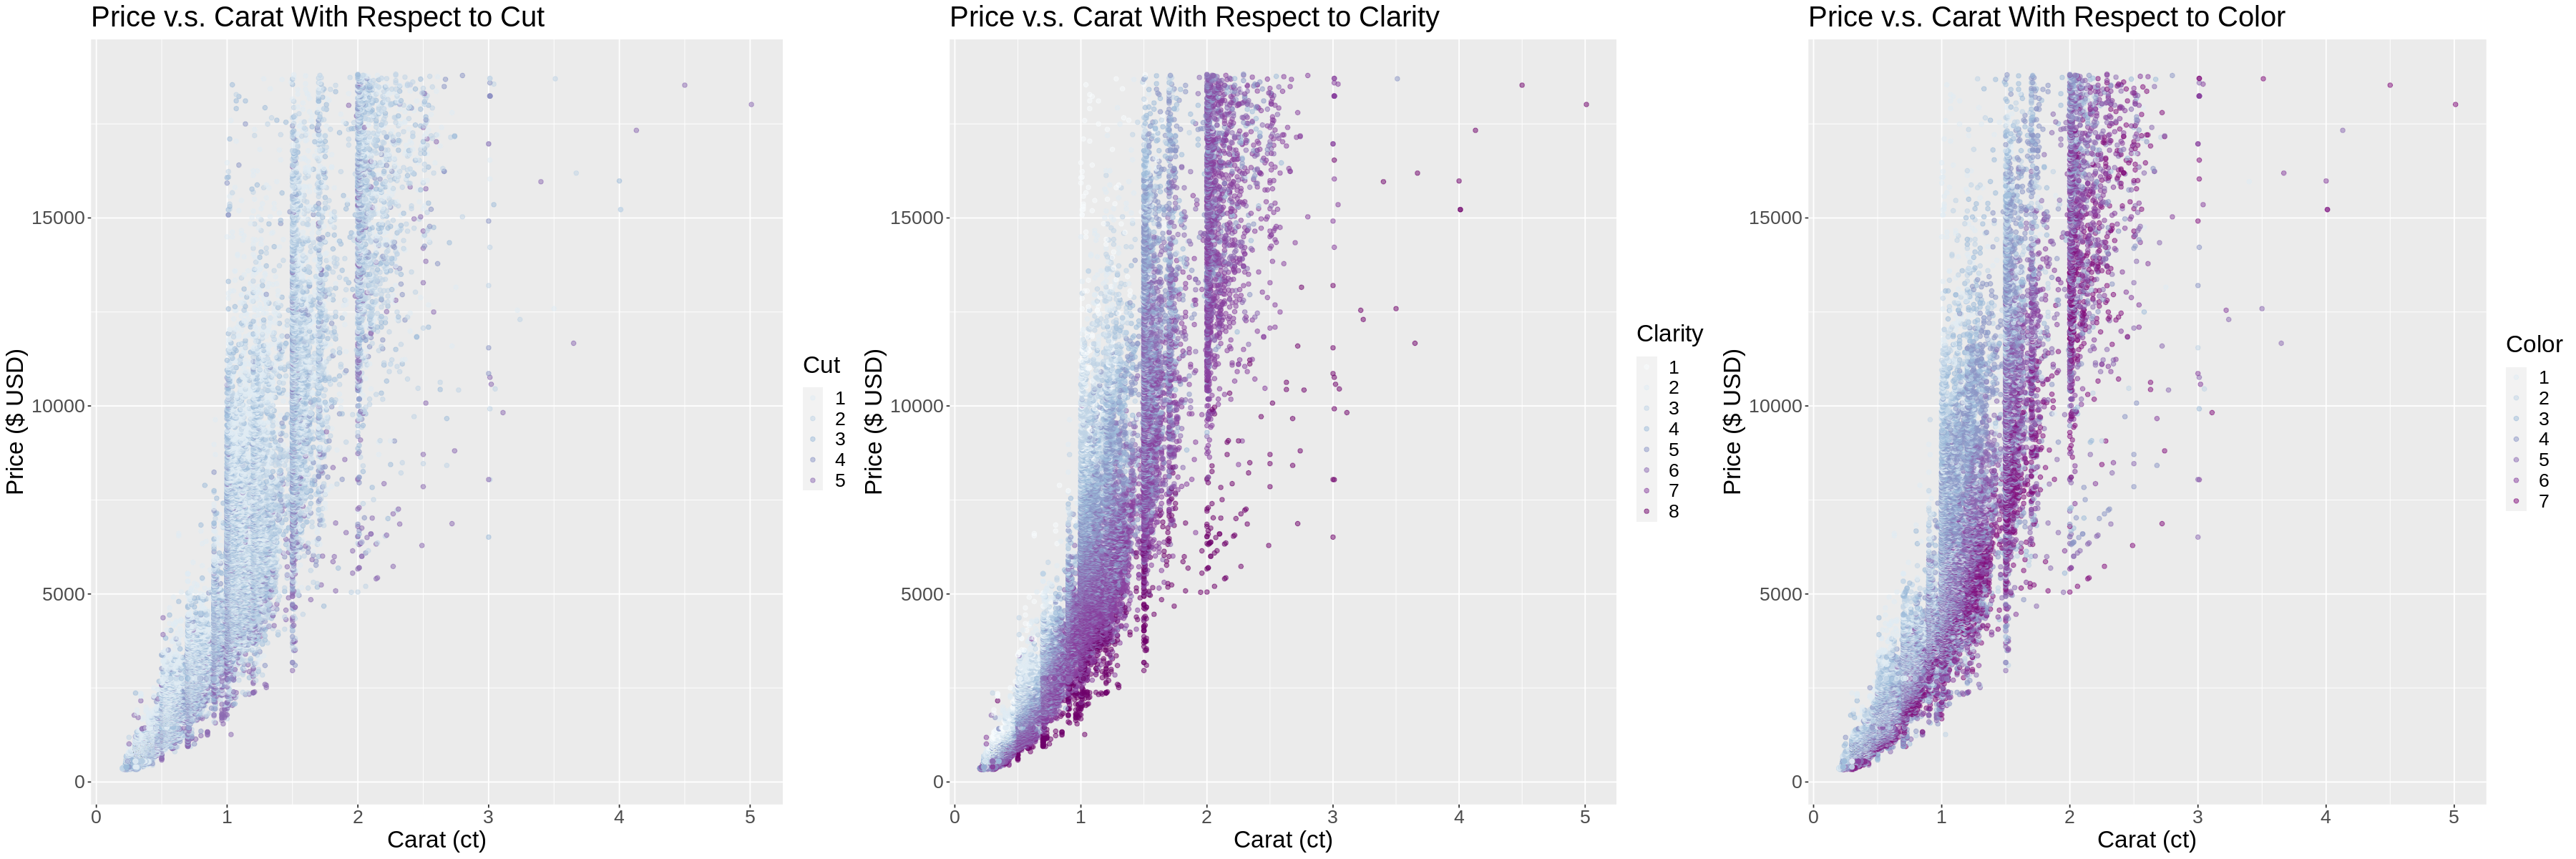

In [150]:
options(repr.plot.width = 30, repr.plot.height = 10)
my_colors <- brewer.pal(4, "BuPu")[2:4]

diamonds_cut_plot <- diamonds_train %>% 
    ggplot(aes(x = carat, y = price, color = factor(cut))) +
    geom_point(alpha = 0.5) +
    labs(title = "Price v.s. Carat With Respect to Cut", x = "Carat (ct)", y = "Price ($ USD)", color = "Cut") +
    scale_color_manual(values = selected_colours) +
    theme(text = element_text(size=20))

diamonds_clarity_plot <- diamonds_train %>% 
    ggplot(aes(x = carat, y = price, color = factor(clarity))) +
    geom_point(alpha = 0.5) +
    labs(title = "Price v.s. Carat With Respect to Clarity", x = "Carat (ct)", y = "Price ($ USD)", color = "Clarity") +
    scale_color_brewer(palette = "BuPu") +
    theme(text = element_text(size=20))

diamonds_color_plot <- diamonds_train %>% 
    ggplot(aes(x = carat, y = price, color = factor(color))) +
    geom_point(alpha = 0.5) +
    labs(title = "Price v.s. Carat With Respect to Color", x = "Carat (ct)", y = "Price ($ USD)", color = "Color") +
    scale_color_manual(values = selected_colours) +
    theme(text = element_text(size=20))
           
plot_grid(diamonds_cut_plot, diamonds_clarity_plot, diamonds_color_plot, nrow = 1)

## 3 Discussion

## 4 References